<a href="https://colab.research.google.com/github/rajiv6741/ML_Assignment_1/blob/main/ML_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob
p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'
traindata = glob.glob(p+'traindata/**/**')
testdata = glob.glob(p+'testdata/**/**')
subjects = pd.read_csv(p+'subjects.csv')
task = pd.read_csv(p+'tasks.csv')
samsub = pd.read_csv(p+'sample_submission.csv')
tdcsfog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'
metadata=pd.concat([tdcsfog_metadata,defog_metadata])

In [ ]:
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/tsflex-0.3.0-py3-none-any.whl
Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/seglearn-1.2.5-py3-none-any.whl


In [ ]:
task['Duration'] = task['End'] - task['Begin']
task = pd.pivot_table(task, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
task.columns = [c[-1] for c in task.columns]
task = task.reset_index()
task['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(task[task.columns[1:]])
subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})


In [ ]:
complex_featlist=['Visit','Test','Medication','s_Visit','s_Age','s_YearsSinceDx','s_UPDRSIII_On','s_UPDRSIII_Off','s_NFOGQ','s_kmeans']
metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()
metadata_complex['Medication']=metadata_complex['Medication'].factorize()[0]

In [ ]:
from seglearn.feature_functions import base_features, emg_features
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)
emg_feats = emg_features()
del emg_feats['simple square integral']

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)
fc = FeatureCollection([basic_feats, emg_feats])

In [ ]:
import pathlib
def reader(f):
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values
        
        df = pd.merge(df, task[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        df.fillna(method="ffill", inplace=True)
        return df
    except: pass
traindata = pd.concat([reader(f) for f in tqdm(traindata)]).fillna(0); print(traindata.shape)
cols = [c for c in traindata.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']


  0%|          | 0/970 [00:00<?, ?it/s]

(20301022, 72)


In [ ]:
traindata=traindata.reset_index(drop=True)

<AxesSubplot:>

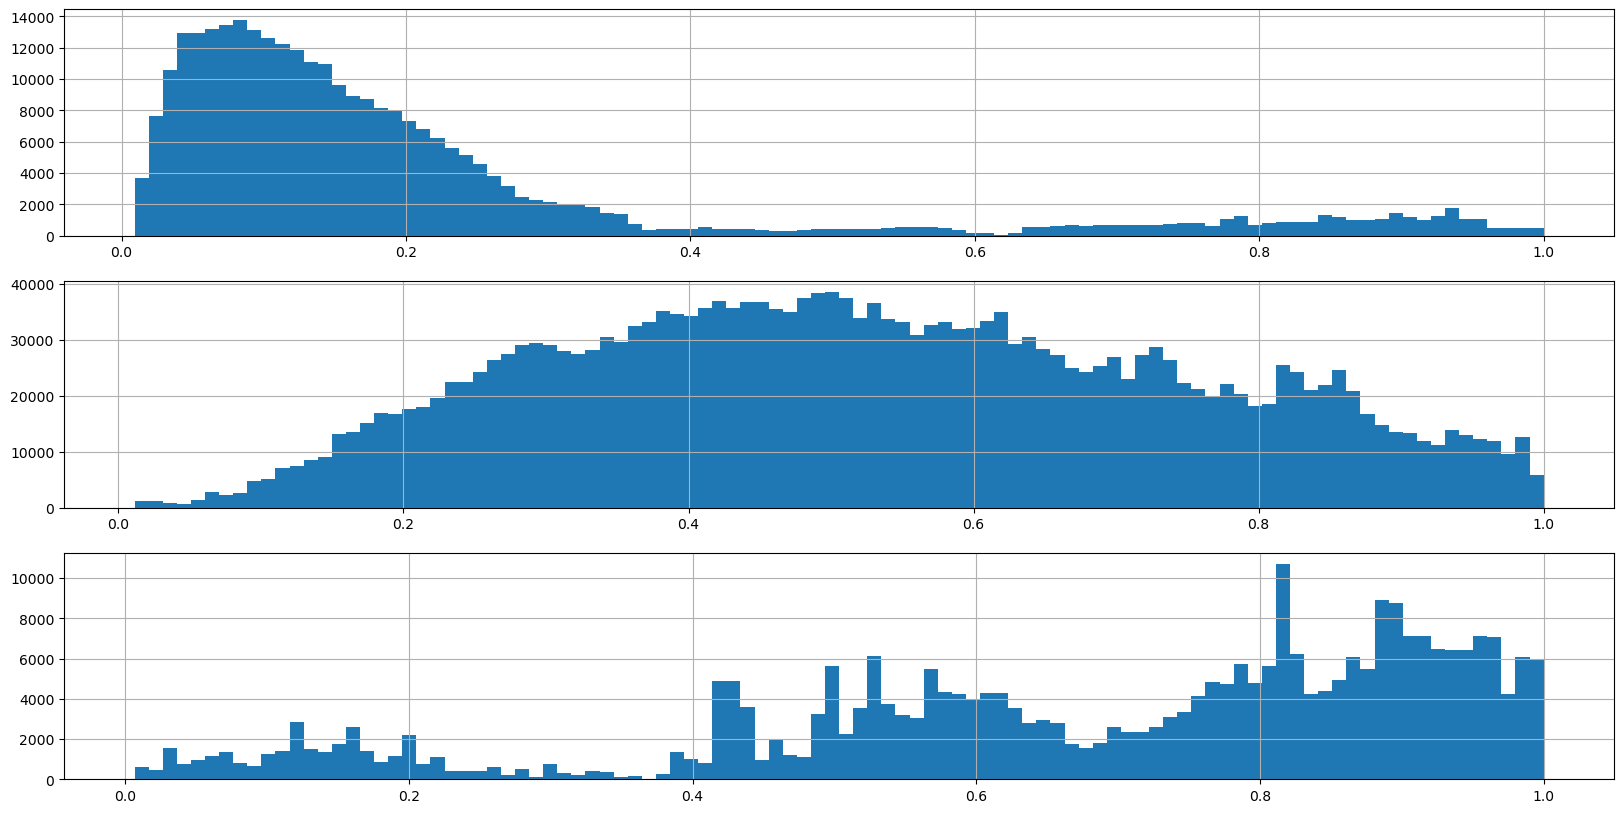

In [ ]:
fig,ax=plt.subplots(3,1,figsize=(20,10))
traindata.loc[traindata['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
traindata.loc[traindata['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
traindata.loc[traindata['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, traindata_testdata_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer
best_params_ = {'estimator__colsample_bytree': 0.548271486, 
 'estimator__learning_rate': 0.24789968, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1999999, 
 'estimator__n_estimators': 288, 
 'estimator__subsample': 0.98098388}

In [ ]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [ ]:
from sklearn.base import clone
def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True
class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)
        return self

In [ ]:
from sklearn.model_selection import GroupKFold
N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = traindata.Subject
groups=kfold.split(traindata, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=traindata.loc[tr_idx,cols].to_numpy(),traindata.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=traindata.loc[te_idx,cols].to_numpy(),traindata.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=25
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0592891	valid_0's average_precision: 0.105081
[2]	valid_0's l2: 0.0592402	valid_0's average_precision: 0.1647
[3]	valid_0's l2: 0.0592886	valid_0's average_precision: 0.193504
[4]	valid_0's l2: 0.0593824	valid_0's average_precision: 0.143542
[5]	valid_0's l2: 0.0581968	valid_0's average_precision: 0.228144
[6]	valid_0's l2: 0.0580793	valid_0's average_precision: 0.25356
[7]	valid_0's l2: 0.0581254	valid_0's average_precision: 0.263817
[8]	valid_0's l2: 0.0581722	valid_0's average_precision: 0.259841
[9]	valid_0's l2: 0.0582307	valid_0's average_precision: 0.233535
[10]	valid_0's l2: 0.0582415	valid_0's average_precision: 0.229277
[11]	valid_0's l2: 0.0581319	valid_0's average_precision: 0.239953
[12]	valid_0's l2: 0.0581416	valid_0's average_precision: 0.235437
[13]	valid_0's l2: 0.0581647	valid_0's average_precision: 0.235006
[14]	valid_0's l2: 0.0581869	valid_0's average_precision: 0.228987
[15]	valid_0's l2: 0.0582672	valid_0's average_precision: 0.218093
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


KeyboardInterrupt: 

In [ ]:
samsub['t'] = 0
submission = []
for f in testdata:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)
    df['Id'] = f.split('/')[-1].split('.')[0]
    df['Time_frac']=(df.index/df.index.max()).values
    df = pd.merge(df, task[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)   
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(samsub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)

In [ ]:
submission